In [106]:
import glob

import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm

import data as data_class
import wifi_label_utils
import scipy

In [109]:

def annotate(filename, label, avg_window_len, avg_duration=-1, debug=False):
    
    data_obj = data_class.Data(filename)

    # use a seconds worth of data to calculate threshold
    if avg_duration > -1:
        iq_samples = data_obj.get_samples(n_samples=int(data_obj.metadata["global"]["core:sample_rate"]*avg_duration))
    else:
        iq_samples = data_obj.get_samples()
        
    avg_pwr = wifi_label_utils.moving_average(iq_samples, avg_window_len)
    avg_pwr_db = 10*np.log10(avg_pwr)

    
    guess_threshold = (np.max(avg_pwr_db) + np.mean(avg_pwr_db))/2
    #guess_threshold = 1.05 * np.max(avg_pwr_db)

    #MAD estimator

    # print(f"{np.quantile(avg_pwr_db, 0.75)=}")
    def median_absolute_deviation(series):
        # print(f"{np.median(series)=}")
        # print(np.abs(series-np.median(series)))
        # print(np.median(np.abs(series - np.median(series))))
        mad = 1.4826 * np.median(np.abs(series - np.median(series)))
        # print(f"{mad=}")
        # sci_mad = scipy.stats.median_abs_deviation(series, scale="normal")
        # print(f"{sci_mad=}")
        return np.median(series) + 6*mad

    mad = median_absolute_deviation(avg_pwr_db)
    guess_threshold = mad
    
    if debug:
        print(f"{np.max(avg_pwr_db)=}")
        print(f"{np.mean(avg_pwr_db)=}")
        print(f"median absolute deviation threshold = {mad}")
        print(f"{guess_threshold=}")
        print(f"{len(avg_pwr_db)=}")
        
        plt.figure()
        #plt.plot(avg_pwr_db[int(0*20480000e-2):int(avg_duration*20.48e6)])
        db_plot = avg_pwr_db[int(0*20.48e6):int(avg_duration*20.48e6)]
        # db_plot = avg_pwr_db[int(0.945*20.48e6):int(0.95*20.48e6)]
        # print(f"{len(db_plot)=}")
        plt.plot(db_plot)
        plt.axhline(y = guess_threshold, color = 'g', linestyle = '-') 
        plt.axhline(y = np.mean(avg_pwr_db), color = 'r', linestyle = '-') 
        plt.axhline(y = mad, color = 'b', linestyle = '-') 
        plt.show()
        
    wifi_label_utils.annotate_power_squelch(data_obj, label, guess_threshold, avg_window_len, skip_validate=True)


  0%|                                                                        | 0/8 [00:00<?, ?it/s]


Loaded 
 Data file: data/gamutrf/gamutrf-sd-gr-ieee-wifi/v2_host/gain_20/wifi-encoding-3-sendsps-20000000.s16.zst.sigmf-data 
 SigMF-Meta file: data/gamutrf/gamutrf-sd-gr-ieee-wifi/v2_host/gain_20/wifi-encoding-3-sendsps-20000000.s16.zst.sigmf-meta

np.max(avg_pwr_db)=-54.33708781707148
np.mean(avg_pwr_db)=-62.28645773425074
median absolute deviation threshold = -60.55512450265955
guess_threshold=-60.55512450265955
len(avg_pwr_db)=81919745


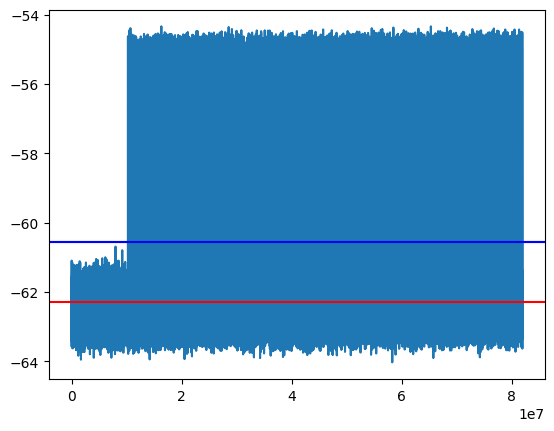

  0%|                                                                        | 0/8 [01:33<?, ?it/s]


In [110]:
for f in tqdm(glob.glob("data/gamutrf/gamutrf-sd-gr-ieee-wifi/v2_host/gain_20/wifi*.sigmf-meta")):
    annotate(f, label="wifi", avg_window_len=256, avg_duration=4, debug=True)
    break
    
# for f in tqdm(glob.glob("data/gamutrf/gamutrf-sd-gr-ieee-wifi/gain_40/anom*.sigmf-meta")):
#     annotate(f, label="anom_wifi", avg_window_len=256, avg_duration=4, debug=False)


In [4]:
import os
import torch
import torchsig

import numpy as np
import torch.nn.functional as F
import torchsig.transforms as ST

from datetime import datetime
from matplotlib import pyplot as plt
from models import CustomNetwork
from pathlib import Path
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from sigmf_db_dataset import SigMFDB
from sigmf_pytorch_dataset import SigMFDataset
from sklearn.metrics import classification_report
from torch import optim
from torch.utils.data import DataLoader
from torchsig.datasets.sig53 import Sig53
from torchsig.models.iq_models.efficientnet.efficientnet import efficientnet_b4
from torchsig.transforms import (
    Compose,
    IQImbalance,
    Normalize,
    RandomApply,
    RandomFrequencyShift,
    RandomPhaseShift,
    RandomResample,
    RandomTimeShift,
    RayleighFadingChannel,
    TargetSNR,
    ComplexTo2D,
)
from torchsig.utils.cm_plotter import plot_confusion_matrix
from torchsig.utils.dataset import SignalDataset
from torchsig.utils.visualize import IQVisualizer, SpectrogramVisualizer, two_channel_to_complex
from tqdm import tqdm
from typing import List


In [5]:

#dataset_path = "./dev_data/torchsig_test/gamutrf-sd-gr-ieee-wifi"
dataset_path = "./data/gamutrf/gamutrf-sd-gr-ieee-wifi"
num_iq_samples = 1024
idx_to_class = {
  0: 'anom_wifi',
  1: 'mini2_telem',
  2: 'mini2_video',
  3: 'wifi6',
  4: 'wifi',
  5: 'fhss_css'
}

In [6]:
transform = ST.Compose([
    # ST.RandomPhaseShift(phase_offset=(-1, 1)),
    ST.Normalize(norm=np.inf),
    ST.ComplexTo2D(),
])
dataset = SigMFDataset( 
    root=dataset_path, 
    sample_count= num_iq_samples, 
    class_list = list(idx_to_class.values()),
    transform = transform,
    only_first_samples=False,
)
dataset_class_counts = {class_name:0 for class_name in dataset.class_list}
for data,label in dataset:
    dataset_class_counts[dataset.class_list[label]] += 1
print(f"{len(dataset)=}")
print(dataset_class_counts)

Class List: ['anom_wifi', 'mini2_telem', 'mini2_video', 'wifi6', 'wifi', 'fhss_css']
len(dataset)=471979
{'anom_wifi': 229527, 'mini2_telem': 0, 'mini2_video': 0, 'wifi6': 0, 'wifi': 242452, 'fhss_css': 0}


In [7]:
dataloader = DataLoader(
    dataset=dataset,
    batch_size=180,
    num_workers=16,
    shuffle=False,
    drop_last=True,
)

In [24]:
next(iter(dataloader))

[tensor([[[ 0.2169, -0.3254,  0.0000,  ...,  0.2169, -0.2169,  0.1085],
          [ 0.3254,  0.1085, -0.1152,  ...,  0.6508, -0.2169, -0.3254]],
 
         [[ 0.0000, -0.0070,  0.0000,  ..., -0.5625, -0.4500, -0.1125],
          [ 0.1125,  0.2250, -0.1125,  ..., -0.2320, -0.3375, -0.4500]],
 
         [[ 0.3175,  0.0992,  0.2117,  ..., -0.3175, -0.4234, -0.3242],
          [-0.3175, -0.3242, -0.2117,  ...,  0.0000,  0.3109,  0.5292]],
 
         ...,
 
         [[ 0.4339,  0.6508,  0.4271,  ...,  0.4271,  0.3254,  0.3254],
          [-0.2169, -0.3322, -0.1085,  ..., -0.1085,  0.1085,  0.0000]],
 
         [[ 0.1118,  0.1118, -0.3424,  ..., -0.3354, -0.1118,  0.2236],
          [ 0.0000, -0.2236, -0.4472,  ...,  0.1048, -0.3354, -0.2236]],
 
         [[ 0.0000,  0.0952,  0.0000,  ..., -0.1015,  0.0000,  0.2031],
          [ 0.1967,  0.2031,  0.1015,  ..., -0.2031, -0.3046,  0.0000]]],
        dtype=torch.float64),
 tensor([4, 4, 0, 4, 0, 4, 4, 0, 0, 4, 0, 4, 0, 4, 4, 4, 0, 0, 4, 0, 0, 4

In [8]:
model = torch.jit.load('weights/checkpoint-v19_torchscript.pt')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

example_model = CustomNetwork(model, dataloader)

example_model = example_model.eval()
example_model = example_model.cuda() if torch.cuda.is_available() else example_model

In [9]:
# Infer results over validation set
num_test_examples = len(dataset)
y_preds = np.zeros((num_test_examples,))
y_true = np.zeros((num_test_examples,))
y_true_list = []
y_preds_list = []
with torch.no_grad():
    example_model.eval()
    for data, label in tqdm(dataloader):
        # Infer
        data = data.float()

        data = data.cuda() if torch.cuda.is_available() else data
        pred_tmp = example_model.predict(data)
        pred_tmp = pred_tmp.cpu().numpy() if torch.cuda.is_available() else pred_tmp

        y_preds_list.extend(np.argmax(pred_tmp, axis=1).tolist())
        y_true_list.extend(label.tolist())
        
y_preds = y_preds_list
y_true = y_true_list

100%|██████████████████████████████████████████████████████████| 2622/2622 [02:47<00:00, 15.64it/s]


/home/ltindall/.pyenv/versions/3.10.9/envs/rfml-dev/lib/python3.10/site-packages/torchsig/utils/cm_plotter.py:31: RuntimeWarning: invalid value encountered in divide
  cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]


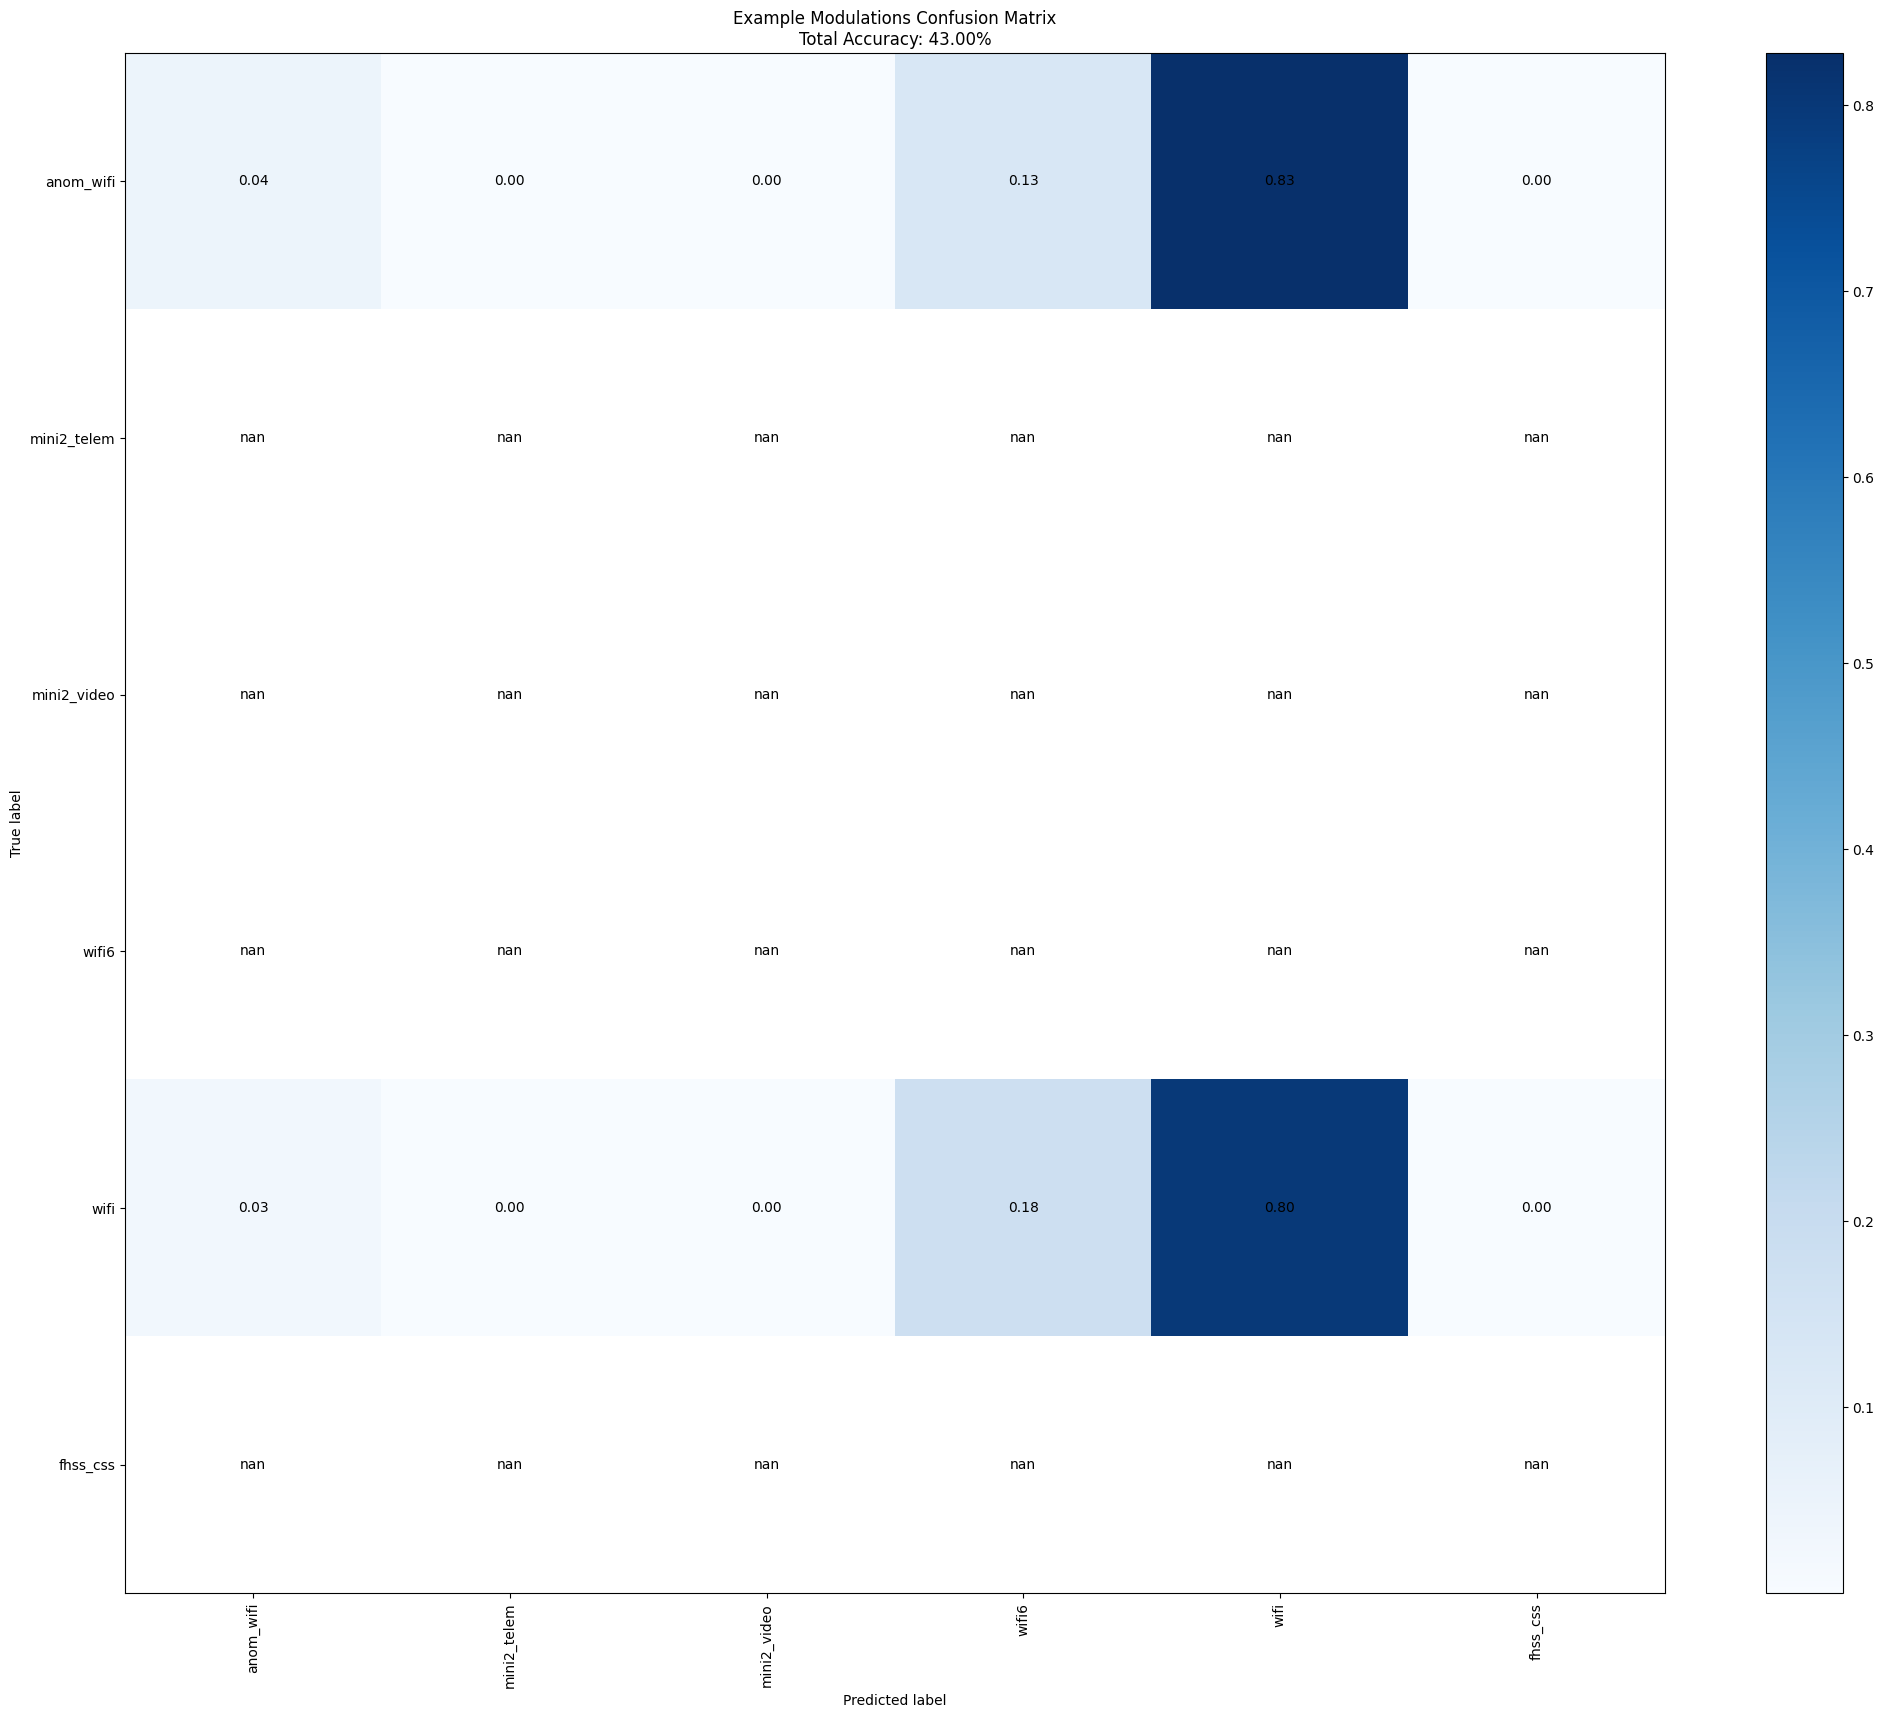

In [19]:
acc = np.sum(np.asarray(y_preds)==np.asarray(y_true))/len(y_true)
plot_confusion_matrix(
    y_true, 
    y_preds, 
    classes=dataset.class_list,#np.unique(y_preds),#np.unique(np.concatenate((np.arange(len(dataset.class_list)),np.unique(y_preds)))),
    normalize=True,
    title="Example Modulations Confusion Matrix\nTotal Accuracy: {:.2f}%".format(acc*100),
    text=True,
    rotate_x_text=90,
    figsize=(26,20),
)
plt.show()

In [17]:
next(dataset.get_weighted_sampler())

TypeError: 'WeightedRandomSampler' object is not an iterator

In [18]:
dataset.class_list

['anom_wifi', 'mini2_telem', 'mini2_video', 'wifi6', 'wifi', 'fhss_css']

In [20]:
list(idx_to_class.values())

['anom_wifi', 'mini2_telem', 'mini2_video', 'wifi6', 'wifi', 'fhss_css']